# Deep Learning avec Python pour la prédiction boursière

Source : https://www.coursera.org/learn/prediction-bourse-python-lstm-streamlit

## Importation des bibliothèques requises

In [1]:
# S'assurer de m'être à jour les bibliothèques
# Pour executer cette cellules, enlevez les commentaires "#"

# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as data
from datetime import datetime
import yfinance as yf
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')
#current_dir = %cd /content/drive/My Drive/Colab Notebooks/

## Importation des données boursières

In [4]:
# Saisir et formater la date d'aujourd'hui sous le format yyyy-mm-dd
now = datetime.now()
today = now.strftime("%Y-%m-%d")
today

'2023-08-05'

In [66]:
# Parametres
ticker = yf.Ticker('SAN.PA') #SAN.PA = Crédit Agricole
debut = '2013-09-01'
fin = '2023-08-03'
df = ticker.history(start=debut, end=today)
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-07-31 00:00:00+02:00,95.419998,98.080002,95.070000,97.089996,1915709,0.0,0.0
2023-08-01 00:00:00+02:00,97.940002,98.430000,96.580002,96.580002,1362640,0.0,0.0
2023-08-02 00:00:00+02:00,96.029999,96.139999,94.629997,94.870003,1606889,0.0,0.0
2023-08-03 00:00:00+02:00,93.800003,94.110001,91.610001,92.220001,2102457,0.0,0.0
2023-08-04 00:00:00+02:00,93.139999,94.239998,92.790001,93.919998,1329811,0.0,0.0


In [65]:
# Conversion du format datetime en date
df.index = pd.to_datetime(df.index).date
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2023-07-31,95.419998,98.080002,95.070000,97.089996,1915709,0.0,0.0
2023-08-01,97.940002,98.430000,96.580002,96.580002,1362640,0.0,0.0
2023-08-02,96.029999,96.139999,94.629997,94.870003,1606889,0.0,0.0
2023-08-03,93.800003,94.110001,91.610001,92.220001,2102457,0.0,0.0
2023-08-04,93.139999,94.239998,92.790001,93.919998,1329811,0.0,0.0


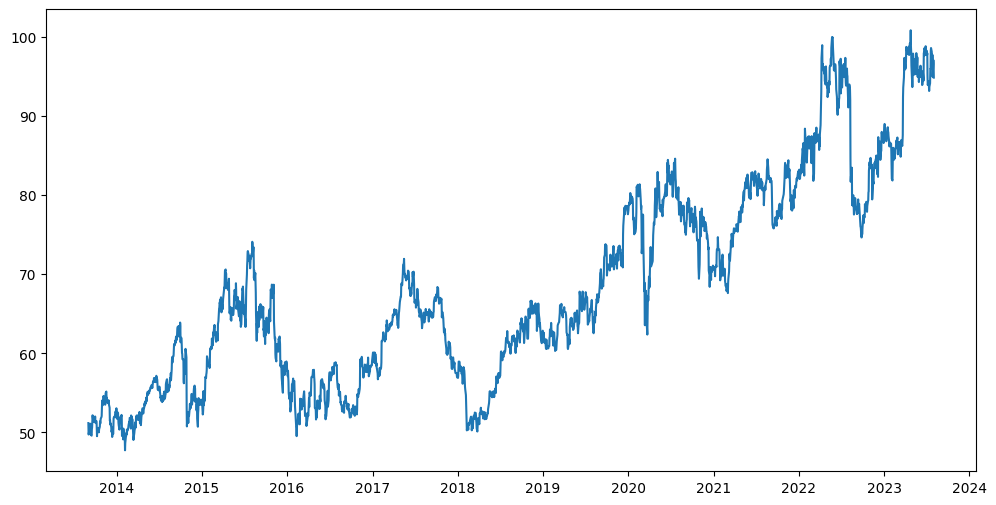

In [7]:
# Visualisation de l'historique
plt.figure(figsize=(12,6))
plt.plot(df.Close)

## Nettoyage des données

In [8]:
# Ajout d'un index de ligne
df = df.reset_index()
df.head()

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2013-09-02,50.457689,51.228142,50.368263,51.179989,1799732,0.0,0.0
1,2013-09-03,51.379485,51.386361,49.645967,49.735397,3253420,0.0,0.0
2,2013-09-04,49.976156,50.127495,49.185066,49.866089,2919038,0.0,0.0
3,2013-09-05,49.907371,50.416418,49.611573,50.113739,2760481,0.0,0.0
4,2013-09-06,50.216928,50.952984,50.024316,50.952984,3589555,0.0,0.0


In [9]:
# Suppression des colonnes inutiles
df.info()
df = df.drop(['Dividends','Stock Splits'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540 entries, 0 to 2539
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         2540 non-null   object 
 1   Open          2540 non-null   float64
 2   High          2540 non-null   float64
 3   Low           2540 non-null   float64
 4   Close         2540 non-null   float64
 5   Volume        2540 non-null   int64  
 6   Dividends     2540 non-null   float64
 7   Stock Splits  2540 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 158.9+ KB


In [10]:
df.tail()

,index,Open,High,Low,Close,Volume
2535,2023-07-27,97.080002,98.199997,96.779999,97.750000,1423525
2536,2023-07-28,97.209999,97.550003,93.750000,94.959999,2354562
2537,2023-07-31,95.419998,98.080002,95.070000,97.089996,1915709
2538,2023-08-01,97.940002,98.430000,96.580002,96.580002,1362640
2539,2023-08-02,96.029999,96.139999,94.629997,94.870003,1606889


In [11]:
 # Description statistique des colonnes numériques
 df.describe()

,Open,High,Low,Close,Volume
count,2540.000000,2540.000000,2540.000000,2540.000000,2.540000e+03
mean,68.233588,68.852080,67.608028,68.239057,2.490612e+06
std,12.886955,13.017435,12.757139,12.899424,1.188335e+06
min,48.400862,48.717297,46.976898,47.740471,0.000000e+00
25%,57.417120,57.952966,56.813365,57.400637,1.786728e+06
50%,65.415755,66.036407,64.838177,65.348053,2.254754e+06
75%,78.349599,78.958226,77.673862,78.416634,2.914815e+06
max,100.508961,101.395859,99.853426,100.856010,1.593795e+07


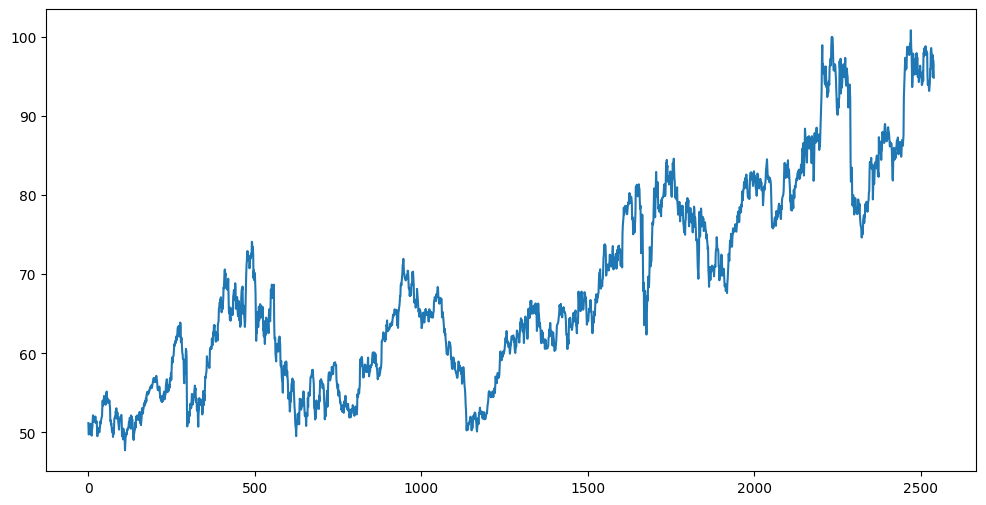

In [12]:
# Tracer
plt.figure(figsize=(12,6))
plt.plot(df.Close)

In [13]:
# Préparation des données de moyenne mobile X jours (Moving Average)
ma100 = df.Close.rolling(100).mean()
ma100

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
2535    95.158185
2536    95.248070
2537    95.351735
2538    95.451940
2539    95.534177
Name: Close, Length: 2540, dtype: float64

In [14]:
ma200 = df.Close.rolling(200).mean()
ma200

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
2535    89.966474
2536    90.048098
2537    90.137720
2538    90.226769
2539    90.311028
Name: Close, Length: 2540, dtype: float64

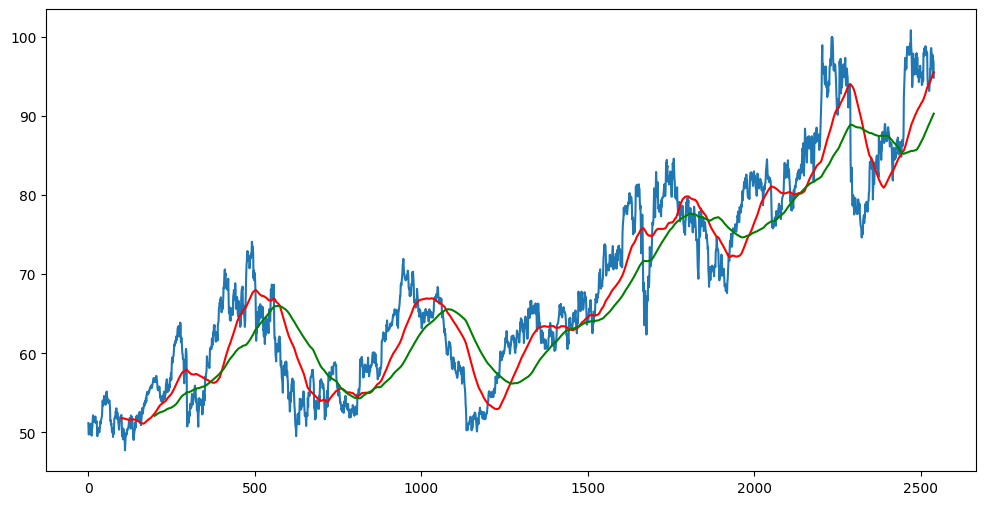

In [15]:
 # Visualisation de le courbe de la moyenne mobile à 100 et 200 jours et du prix de clôture en fonction du temps
 plt.figure(figsize=(12,6))
 plt.plot(df.Close)
 plt.plot(ma100,'r')
 plt.plot(ma200,'g')

## Division des données

In [16]:
# Division des données en Training dataset et Testing dataset
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.7):int(len(df))])

print(data_training.shape)
print(data_testing.shape)

(1778, 1)
(762, 1)


In [17]:
data_training.tail()

,Close
1773,77.824341
1774,78.640984
1775,79.152512
1776,78.066635
1777,76.693588


In [18]:
data_testing.head()

,Close
1778,77.635880
1779,78.416634
1780,78.649963
1781,78.048691
1782,77.483315


In [19]:
data_testing.tail()

,Close
2535,97.750000
2536,94.959999
2537,97.089996
2538,96.580002
2539,94.870003


## Scaling des données d'entraînement

In [20]:
# Normalisation des valeurs <=> plage comprise entre 0 et 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_training_array = scaler.fit_transform(data_training)
data_training_array.shape

(1778, 1)

\begin{align}
X_{\text{scaled}} = \frac{{X - X_{\text{min}}}}{{X_{\text{max}} - X_{\text{min}}}}
\end{align}

In [21]:
data_training_array.min()

0.0

In [22]:
data_training_array.max()

1.0000000000000002

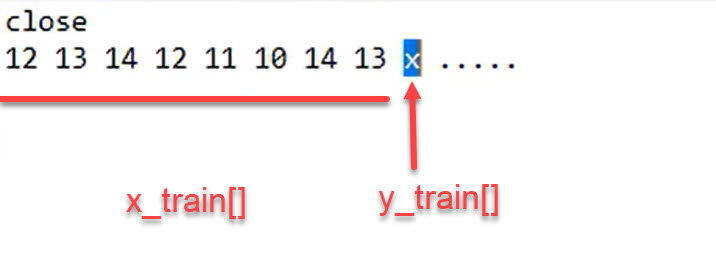

In [23]:
# Division de x_train et y_train par pas de 100 jours
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
  x_train.append(data_training_array[i-100 : i ])
  y_train.append(data_training_array[i, 0])

In [24]:
# Conversion de x_train et y_train en matrices
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape)
print(y_train.shape)

(1678, 100, 1)
(1678,)


## Combiner les données de training et de test

In [25]:
# Combiner les 100 dernières lignes du training dataset avant les premières lignes du Testing dataset
past_100_days = data_training.tail(100)
data_testing = past_100_days.append(data_testing, ignore_index=True)
data_testing

<ipython-input-25-d7861b365625>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_testing = past_100_days.append(data_testing, ignore_index=True)


,Close
0,66.487747
1,67.266899
2,66.660896
3,69.699593
4,69.379272
...,...
857,97.750000
858,94.959999
859,97.089996
860,96.580002


## Scaling des données de test

In [26]:
# Normalisation des valeurs <=> plage comprise entre 0 et 1
scaler2 = MinMaxScaler(feature_range=(0,1))
data_testing_array = scaler2.fit_transform(data_testing)
data_testing_array.shape

(862, 1)

In [27]:
# Division de x_test et y_test par pas de 100 jours
x_test = []
y_test = []

for i in range(100, data_testing_array.shape[0]):
  x_test.append(data_testing_array[i-100 : i ])
  y_test.append(data_testing_array[i, 0])

In [28]:
# Conversion de x_test et y_test en matrices
x_test, y_test = np.array(x_test), np.array(y_test)

print(x_test.shape)
print(y_test.shape)

(762, 100, 1)
(762,)


## Création du modèle Deep Learning LSTM

In [29]:
x_train.shape

(1678, 100, 1)

In [30]:
x_train.shape[1]

100

In [31]:
# Création du modèle - ajout de plusieurs couches de neurones
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [ ]:
# Compilation et training du modèle
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 50)

Epoch 1/50
53/53 [==============================] - 57s 734ms/step - loss: 0.0409
Epoch 2/50
53/53 [==============================] - 41s 786ms/step - loss: 0.0135
Epoch 3/50
53/53 [==============================] - 49s 935ms/step - loss: 0.0098
Epoch 4/50
53/53 [==============================] - 39s 719ms/step - loss: 0.0090
Epoch 5/50
53/53 [==============================] - 38s 715ms/step - loss: 0.0091
Epoch 6/50
53/53 [==============================] - 41s 763ms/step - loss: 0.0085
Epoch 7/50
53/53 [==============================] - 39s 724ms/step - loss: 0.0078
Epoch 8/50
53/53 [==============================] - 38s 724ms/step - loss: 0.0071
Epoch 9/50
53/53 [==============================] - 38s 719ms/step - loss: 0.0077
Epoch 10/50
53/53 [==============================] - 40s 756ms/step - loss: 0.0069
Epoch 11/50
53/53 [==============================] - 46s 869ms/step - loss: 0.0067
Epoch 12/50
53/53 [==============================] - 44s 829ms/step - loss: 0.0066
Epoch 13/50
5

In [77]:
# Enregistrement du modèle
model.save('keras_model.h5')

## Evaluation du modèle

In [42]:
 print(x_test.shape)
 print(y_test.shape)

(762, 100, 1)
(762,)


In [41]:
# Prédictions pour x_test
y_pred = model.predict(x_test)
y_pred.shape

24/24 [==============================] - 1s 61ms/step


(762, 1)

In [40]:
# Récupérer le facteur de scaling
scaler2.scale_

array([0.02909661])

In [68]:
# Dénormaliser les données !
scale_factor = 1 / scaler2.scale_
print("scaling factor : ", scale_factor)
#y_predict = y_pred * scale_factor
#y_testing = y_test * scale_factor
y_test_2d = np.reshape(y_test, (-1, 1))

y_predict = scaler2.inverse_transform(y_pred)
y_testing = scaler2.inverse_transform(y_test_2d)

scaling factor :  [34.36826324]


\begin{align}
X = X_{\text{scaled}} \times (X_{\text{max}} - X_{\text{min}}) + X_{\text{min}}
\end{align}

In [69]:
y_predict[-1], y_testing[-1]

(array([93.40034], dtype=float32), array([94.87000275]))

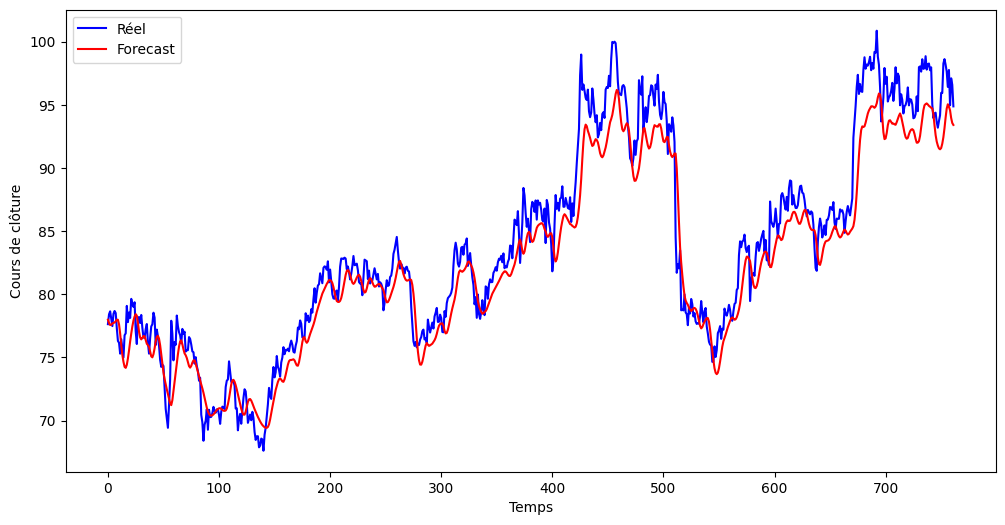

In [70]:
# Visionner la courbe de prédiction des cours de clôture VS le cours de clôture
plt.figure(figsize=(12,6))
plt.plot(y_testing,'b',label='Réel')
plt.plot(y_predict,'r',label='Forecast')
plt.xlabel('Temps')
plt.ylabel('Cours de clôture')
plt.legend()
plt.show()

In [71]:
# Prédiction du cours de clôture pour demain
x = []
x.append(y_test[-100:])
x = np.array(x)
x.shape

(1, 100)

In [72]:
# Attention la couche LSTM attend des données d'entrée tridimensionnelles de la forme (batch_size, timesteps, input_dim)
x = x.reshape((x.shape[0], x.shape[1], 1))
x.shape

(1, 100, 1)

In [73]:
pred_tomorrow = model.predict(x)
pred_tomorrow.shape

1/1 [==============================] - 0s 78ms/step


(1, 1)

In [75]:
# Affichage
#pred = pred_tomorrow * scale_factor
pred = scaler2.inverse_transform(pred_tomorrow)
print("Le prix de clôture pour aujourd'hui est :", y_testing[-1],"\nLe prix de clôture prédit pour demain est : ", float(pred))

Le prix de clôture pour aujourd'hui est : [94.87000275] 
Le prix de clôture prédit pour demain est :  93.18936157226562


## Interprétation des résultats

Le cours réel devrait être de l'ordre de 95 euros au 03/08/2023, mais ce n'était pas le cas ni pour y_testing, ni pour pred_tomorrow.

=> Il y a un problème avec l'inversion de la transformation d'échelle.
**Solution** : utiliser la fonction scaler.inverse_transform() au lieu d'un simple facteur d'échelle scaler_factor !

=> Mais ne fonctionne pas avec y_test car c'est un tableau 1D.
**Solution** : transformer d'abord y_test en tableau 2D => y_test_2d = np.reshape(y_test, (-1, 1)), puis appliquer scaler.inverse_transform()

Comment effectuer une prédiction sur une période future, par exemple 30 jours.

Puis tracer la courbe de forecast ?